# Analyzing NYC High School SAT Scores

*Note: This project is a continuation from [Dataquest.io](https://www.dataquest.io)*. 

In this project, we will be analyzing datasets compiled from [NYC Open Data](https://opendata.cityofnewyork.us) to see what factors affect high school students' performances on the SAT (Scholastic Aptitude Test) throughout New York City.

Specifically, we will be combining and examining data from the following datasets:

* [SAT Scores by School](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) -- SAT scores for each high school in NYC
* [School Attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) --     Attendance and enrollment statistics broken down by school district 
* [Class Size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) -- Average class sizes for each school, by grade and program type
* [AP Test Results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) -- AP (Advanced Placement) testing results for each high school
* [Graduation Outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) -- Graduation rates for each school 
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) -- Demographic information for each school
* [School Survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) -- Surveys of parents, teachers, and students at each school

Since New York City has a very large immigrant population and thus high student diversity, it will be interesting to see what effects demographic factors such as race, income and gender have on SAT scores. Moreover, are there less obvious factors such as class size or school location that influence SAT scores? Once we clean and combine the data, we delve into these analyses.

## 1. Read in the data

We read the datasets into the `data` dictionary with the key of each dataset coming from `data_files`. 

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
data_files = [          
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for file in data_files:  
    data[file.split(".")[0]] = pd.read_csv("./input/schools/{0}".format(file))

for key in data: 
    print(data[key].head(3))
    print(data[key].shape)

    Demographic     DBN                            School Name Cohort  \
0  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2003   
1  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2004   
2  Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2005   

   Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
0             5               s                         s                 s   
1            55              37                     67.3%                17   
2            64              43                     67.2%                27   

  Total Regents - % of cohort Total Regents - % of grads  \
0                           s                          s   
1                       30.9%                      45.9%   
2                       42.2%                      62.8%   

             ...            Regents w/o Advanced - n  \
0            ...                                   s   
1            ...                     

One thing to note is that **each school has a unique `DBN`**, or District Borough Number. We wish to create a `DBN` column for each of the datasets because that is what we will eventually use to join them.  

### Read in the surveys

The survey files are in a `.txt` format so we read them in separately, accounting for their particular encoding. District 75's survey results are in a different file, so we will have to concatenate it to the main survey dataset. After combining the two survey files, we use the data dictionary provided with the survey data to narrow the columns down to the relevant ones selected in `survey_fields`. The selected fields allow us the see how students, parents and teachers feel about their school's safety and academic performance among other things. Finally, the new dataset is added to our `data` dictionary. 

In [3]:
all_survey = pd.read_csv("./input/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("./input/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0) 

# Copy data from "dbn" column to "DBN" so we can use it to join later
survey["DBN"] = survey["dbn"] 

survey_fields = [ 
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Condense dataset according to our selected columns
survey = survey.loc[:,survey_fields] 

data["survey"] = survey 

### Add DBN columns

In order to ensure we can later combine our datasets, we need to check that each one has a `DBN` column. For `hs_directory`, we simply need to copy the values from its `dbn` column over to a new `DBN` column. On the other hand, `class_size` doesn't have any column for the `DBN` so we will need to create one. Looking at the columns in `class_size`, it seems a  `DBN` is a combination of the `CSD` and `SCHOOL CODE` columns, where the `CSD` is always 2 digits. Thus, we have to pad the `CSD` for each school and combine it with its `SCHOOL CODE` to get its `DBN`. 

In [4]:
# Copy data from "dbn" column to "DBN" so we can use it to join later
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"] 


# Function to pad CSD's for class_size
def pad_csd(num): 
    num = str(num)
    if len(num) == 2: 
        return num
    else: 
        return(num.zfill(2))
    
    
# Apply function to the CSD column to get padded_csd
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd) 

# Create DBN column based on our formula
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"] 

print(data["class_size"]["DBN"].unique()[0:5])

['01M015' '01M019' '01M020' '01M034' '01M064']


### Convert columns to numeric  

We convert certain columns such as SAT scores to numeric so that we can conduct analyses on them. We also create an `sat_score` column that combines the average scores of each section of the SAT for each high school. 

Another set of columns we convert to numeric are those regarding AP testing data.  

In [5]:
sat_columns = [                         
    "SAT Math Avg. Score", 
    "SAT Critical Reading Avg. Score", 
    "SAT Writing Avg. Score"
] 

for col in sat_columns: # Convert each column to numeric
    data["sat_results"][col] = pd.to_numeric(data["sat_results"][col], errors="coerce")
    
data["sat_results"]["sat_score"] = (data["sat_results"][sat_columns[0]]  # Create new column for total score
                                   + data["sat_results"][sat_columns[1]] 
                                   + data["sat_results"][sat_columns[2]]) 

ap_columns = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5'] # AP columns to convert to numeric

for col in ap_columns: 
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Parsing school coordinates

The `hs_directory` dataset contains the locations of each high school. We may want to map out the schools in order to see any geographic patterns. So, we will parse the coordinates of each school from the `Location 1` column using regular expressions.

In [6]:
def get_latitude(string): 
    coord = re.findall("\(.+, .+\)", string)  
    latitude = coord[0].split(",")[0].replace("(", "") 
    return latitude

def get_longitude(loc): 
    coord = re.findall("\(.+, .+\)", loc)   
    longitude = coord[0].split(",")[1].replace(")", "")
    return longitude

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(get_latitude)   
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(get_longitude)

data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors = "coerce")  
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors = "coerce")

print(data["hs_directory"][["lat", "lon"]].head()) 

         lat        lon
0  40.670299 -73.961648
1  40.827603 -73.904475
2  40.842414 -73.916162
3  40.710679 -74.000807
4  40.718810 -73.806500


### Condense datasets

We want to condense the datasets so that each value in the `DBN` column is unique. 

For `class_size`, we filter the `GRADE ` column for high school and `PROGRAM TYPE` for general education in order to get the relevant student body. The `DBN` values are not yet unique because of the different class types per grade, so we group by `DBN` and take the mean class size for each school. 

For `demographics`, all we need to do is take the most recent school year to achieve unique `DBN` values. 

Similarly, for `graduation`, we filter by the most recent cohort and select the total cohort. 

Now, all our datasets have unique `DBN` values and are ready to be combined. 

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## 2. Combine the datasets and fill null values

Since we are studying SAT scores, we will start our merging with the `sat_results` dataset and we want to preserve as many rows from this dataset as we can while minimizing null values. We perform left joins with `ap_2010` and `graduation` since these dataset have many missing `DBN` values. For the rest of the datasets, we perform inner joins because they contain information more valuable to our analysis and because they contain fewer missing `DBN` values. Finally, we fill missing values with the mean of each column for numeric columns and 0 otherwise. 

In [8]:
combined = data["sat_results"]

# Left joins on these two datasets
combined = combined.merge(data["ap_2010"], on="DBN", how="left")   
combined = combined.merge(data["graduation"], on="DBN", how="left")

# Inner joins on these datasets
to_merge = ["class_size", "demographics", "survey", "hs_directory"] 

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# Fill null values
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### Add a school district column for mapping

A school's district is the first two characters of the `DBN` so we create a column for each school's district. 

In [9]:
# Function to extract the first two characters of each DBN
def get_district(DBN):
    district = DBN[0:2]
    return district

combined["school_dist"] = combined["DBN"].apply(get_district)

## 3. Data Analysis

### Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]

print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Plotting Survey Correlations

We want to see if any of the survey fields have significant correlation with SAT score, so we plot the fields with R values greater than 0.2 or less than 0 (just to see if any are negatively correlated). We use the dataset's provided dictionary to decipher the fields.

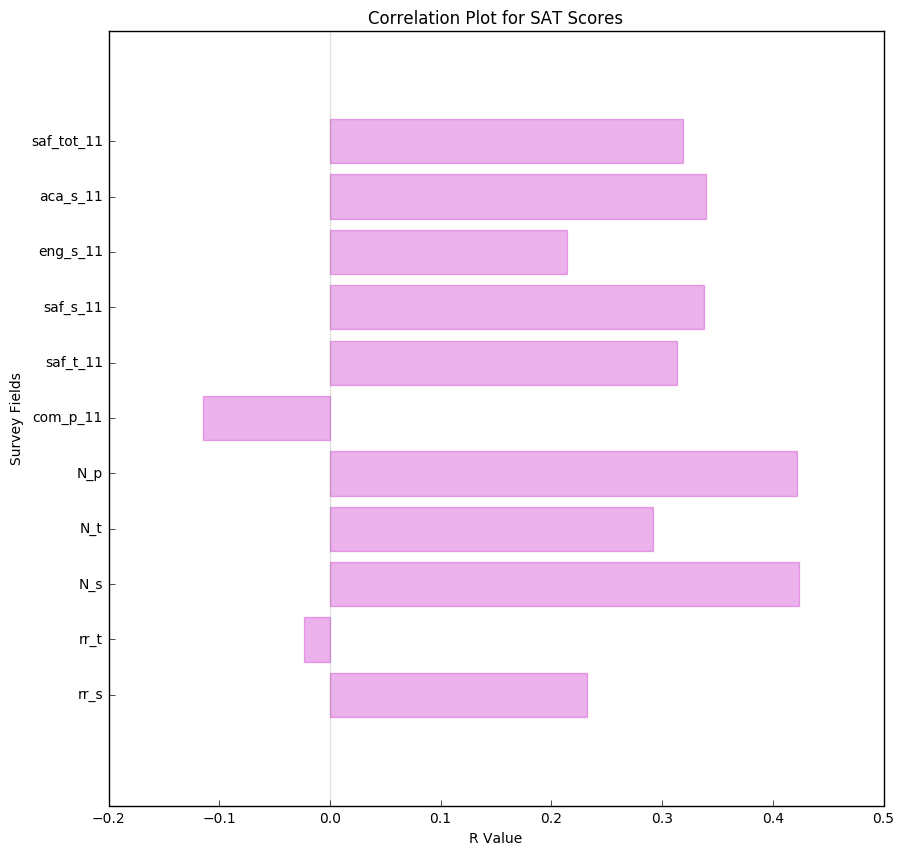

In [11]:
survey_corr = combined.corr()["sat_score"][survey_fields]
survey_corr_plot = survey_corr[(survey_corr > .2) | (survey_corr < 0)]

fig, ax = plt.subplots(figsize=(10,10))

ind = np.arange(len(survey_corr_plot))
height = 0.8

ax.barh(ind, survey_corr_plot, height, align="center", color="m", alpha=0.3, edgecolor='m')

ax.set_title("Correlation Plot for SAT Scores")
ax.set_xlim(-.2, .5)

ax.set_xlabel("R Value")
ax.set_ylabel("Survey Fields")

ax.set_yticks(ind)
ax.set_yticklabels(survey_corr_plot.index)

ax.tick_params(right='off', top='off')
ax.axvline(0, color='grey', alpha=0.25)

plt.show()

There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. These survey fields are the number of responses for students, teacher and parents, respectively. Since these columns are correlated with `total_enrollment`, which has a high correlation with `sat_score`, it follows that they would also be highly correlated with `sat_score`. 

More interestingly, `rr_s`, or the student response rate per school, correlates with `sat_score`. One reason might be that students who are willing to fill out the survey are usually more academically successful. 

The opinion on school safety according to students and teachers (`saf_s_11` and `saf_t_11`) also correlate with `sat_score`, which makes sense as it's harder to learn or teach in an unsafe environment. 

The one field that correlates negatively with `sat_score` somewhat significantly is `com_p_11`, which is the communication score given to the school by the parents. This is odd because it indicates that the more communicative a school is, the lower its SAT scores are, which is contrary to what we might expect. 

Finally, we see that `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`. The same cannot be said for how teachers and parents perceive academic standards. 

### Safety vs. Score

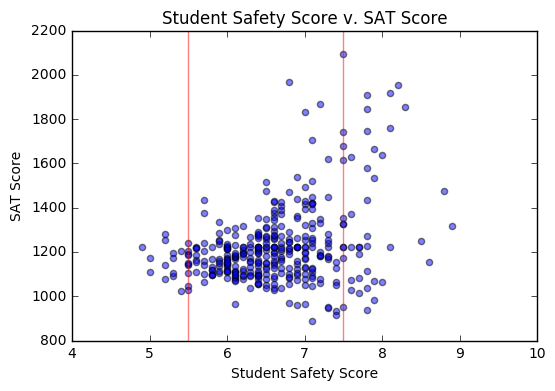

In [12]:
saf = combined.plot.scatter("saf_s_11", "sat_score", alpha=0.5)

saf.set_title("Student Safety Score v. SAT Score")

saf.set_ylabel("SAT Score")
saf.set_xlabel("Student Safety Score")

saf.axvline(5.5, color='red', alpha=0.5)
saf.axvline(7.5, color='red', alpha=0.5)

The data is clustered between safety ratings 5.5 and 7.5 with the SAT score between 1000 and 1400. There is a slight upward trend, but it's not apparent until we go above 7 in safety rating. The few schools with very high SAT scores and safety ratings result in our high R value. While schools with very high SAT scores have a relatively high safety rating, a high safety rating does not mean performance will necessarily be better as there are plenty of schools with high safety ratings and low SAT scores. 

### Mapping districts by saftey rating

Where are the safest school districts according to students? By mapping out safety scores by district, we are trying to see if there any areas in NYC with a large number of safe or unsafe schools and if those districts show any pattern with regard to SAT score. We use the `Basemap` package and aggregate the safety ratings in each school district. 

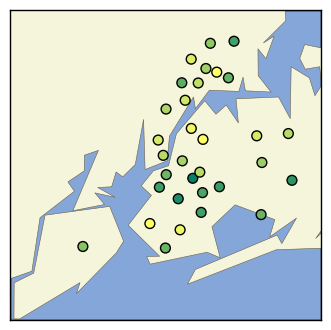

    saf_s_11        lat        lon    sat_score
15  5.875000  40.688008 -73.929686  1120.109701
16  6.007143  40.660313 -73.955636  1161.428571
28  6.075000  40.685276 -73.752740  1181.929851
18  6.150000  40.676547 -73.882158  1103.833333
14  6.177778  40.675972 -73.989255  1190.604312
10  6.186667  40.873138 -73.856120  1165.000000
17  6.190909  40.641863 -73.914726  1118.000000
22  6.233333  40.668586 -73.912298  1157.333333
4   6.314286  40.817077 -73.949251  1285.062687
7   6.364697  40.823803 -73.866087  1159.665129
26  6.390000  40.638828 -73.807823  1224.300000
20  6.390909  40.593596 -73.978465  1206.312619
12  6.407692  40.692865 -73.977016  1237.187600
30  6.530000  40.595680 -74.125726  1382.500000
9   6.577273  40.870345 -73.898360  1222.227273
27  6.627273  40.709344 -73.806367  1347.846947
8   6.655000  40.836349 -73.906240  1131.971940
13  6.685714  40.711599 -73.948360  1179.459915
2   6.716667  40.781574 -73.977370  1293.443035
25  6.760000  40.748507 -73.759176  1377

In [29]:
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='beige',lake_color='light_blue')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()
print(districts[["saf_s_11", "lat", "lon", "sat_score"]].sort_values("saf_s_11"))


Many of the unsafest school districts are clustered in mid-upper Brooklyn. A deeper analysis into the crime data in that area might help us figure out why students feel unsafe in those districts. 

On the other hand, some of the safest school districts are clustered in Manhattan and west Queens. These are where some of the most competitive high schools in the city are located as well as some the highest property values. An interesting analysis would be to compare property values and SAT scores. 

### Race and SAT Score

We now explore correlations between race and SAT scores. Historically, White and Asian students have performed better on the SAT than Black and Hispanic students. The reasons for this discrepancy are beyond the scope of this project, but let's see if this pattern holds in NYC high schools. 

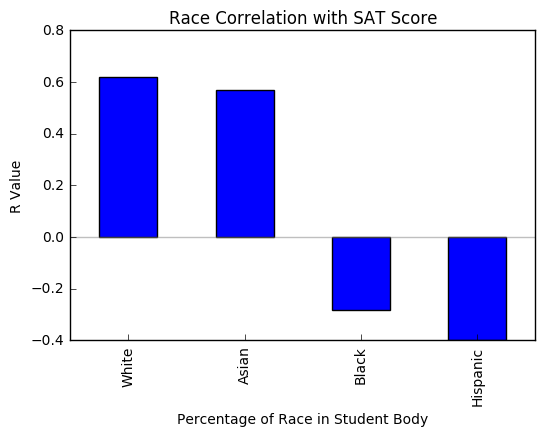

In [14]:
race_cols = ["white_per", "asian_per", "black_per", "hispanic_per"]

race = combined.corr()["sat_score"][race_cols].plot.bar()

race.set_title("Race Correlation with SAT Score")
race.set_xlabel("Percentage of Race in Student Body")
race.set_ylabel("R Value")

race.tick_params(top='off', right='off')
race.axhline(0, color='grey', alpha=0.5)
race.set_xticklabels(["White","Asian","Black","Hispanic"])

The data suggest a strong positive correlation between the percentage of White and Asian students and SAT score. On the other hand, there is a negative correlation between the percentage of Black and Hispanic students and SAT scores. However, these negative correlations are not as strong as the positive ones shown by the percentage of White and Asian students. These correlations support the hypothesis that White and Asian students perform better on the SAT than Black and Hispanic students.

Let's observe the trends for each race.

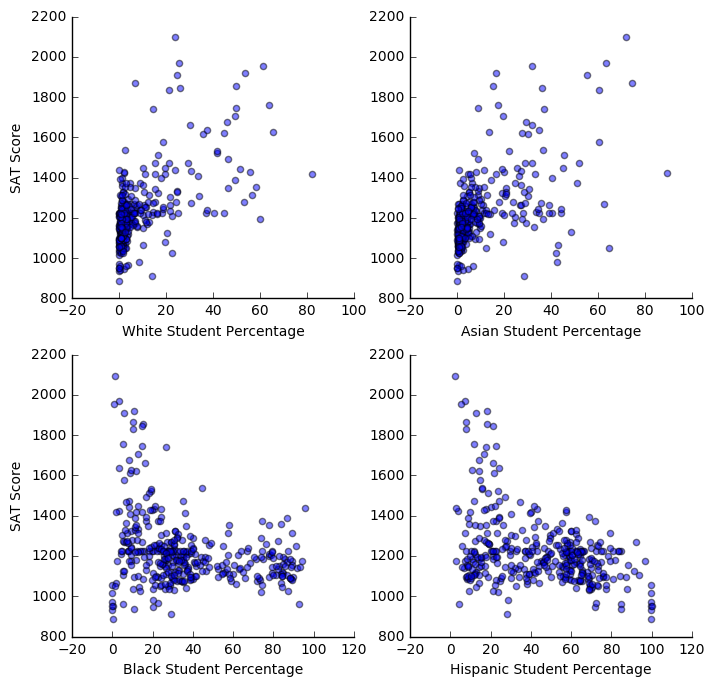

In [15]:
race_fig = plt.figure(figsize=(8,8))

ax1 = race_fig.add_subplot(2,2,1)
ax2 = race_fig.add_subplot(2,2,2)
ax3 = race_fig.add_subplot(2,2,3)
ax4 = race_fig.add_subplot(2,2,4)

ax1.scatter(combined["white_per"], combined["sat_score"], alpha=0.5)
ax2.scatter(combined["asian_per"], combined["sat_score"], alpha=0.5)
ax3.scatter(combined["black_per"], combined["sat_score"], alpha=0.5)
ax4.scatter(combined["hispanic_per"], combined["sat_score"], alpha=0.5)

ax1.set_ylabel("SAT Score")
ax3.set_ylabel("SAT Score")

ax1.set_xlabel("White Student Percentage")
ax2.set_xlabel("Asian Student Percentage")
ax3.set_xlabel("Black Student Percentage")
ax4.set_xlabel("Hispanic Student Percentage")

# Remove spines and ticks
for ax in race_fig.get_axes():
    ax.tick_params(top="off", right="off")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

The data for Black and Hispanic student percentages show a clustering of SAT scores between roughly 1000 and 1400 across all percentages. A small group of schools with low Black and Hispanic student percentages display a much higher SAT score, which contributes to the negative R values. On the other hand, for White and Asian student percentages, the data show a clearer upward trend. Schools with higher White and Asian student percentages tend to produce higher SAT scores. 

In [16]:
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools with more than 95% Hispanic students seem to be international or multicultural schools that support students whose first language is not English. 

In [17]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools with less than 10% Hispanic students and an SAT score above 1800 are technical high schools requiring an entrance exam. 

### Gender Differences

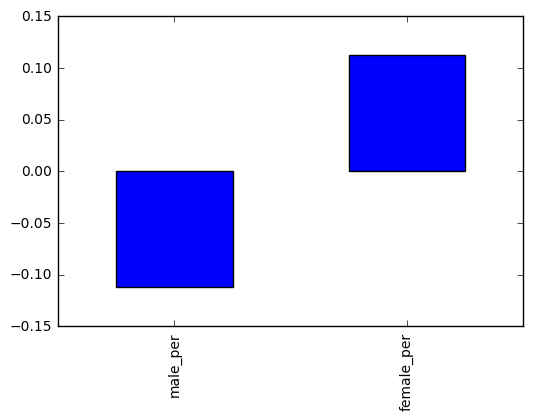

In [18]:
gender_cols = ["male_per", "female_per"]

combined.corr()["sat_score"][gender_cols].plot.bar()

There doesn't seem to a significant correlation between the ratio of male:female students with SAT score. 

## 4. Conclusions

After conducting exploratory data analysis, here are some of our initial findings:

* While safety is not a definitive factor for SAT performance, only schools with a student rating above 6.5 achieved an average SAT score above 1600.
* Many of the least safe school districts are clustered in mid-upper Brooklyn while most of the districts in Manhattan and west Queens are safe. Parents looking for schools in the city might want to consider the safer areas. 
* Schools tend to perform better on the SAT when they have a higher White and Asian student percentage. This bolsters the argument that White and Asian students have better performances on the SAT overall than students of other ethnicities. 
* The gender makeup of a school does not seem to have an effect on its SAT performance. 